<a href="https://colab.research.google.com/github/vasanthsai26/Corp-favorita-store-sales-Time-Series-Forecasting/blob/main/object_localization_and_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OxfordIIITPet Localization and Classification - PyTorch




**Problem Statement**

- Classify and Localize the Pets in the images



**Dataset**



> The Oxford-IIIT Pet Dataset





<img src="https://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg" alt="object_localzation_segmentation" width="600" height="400">


- The Oxford Pets dataset (also known as the "dogs vs cats" dataset) is a collection of images and annotations labeling various breeds of dogs and cats. There are approximately 100 examples of each of the 37 breeds. This dataset contains the object detection portion of the original dataset with bounding boxes around the animals' heads.

> Evaluation Metric

**IOU (Intersection over Union)**

- IOU(Intersection over Union) is a term used to describe the extent of overlap of two boxes. The greater the region of overlap, the greater the IOU.
- It is used to evaluate the performance of object detection by comparing the ground truth bounding box to the preddicted bounding box
-  For example in the image below, we have a green box, and a red box. The green box represents the  ground truth box, and the red box represents the prediction from our model. The aim of this model would be to keep improving its prediction, until the red box and the green box perfectly overlap, i.e the IOU between the two boxes becomes equal to 1.


<img src="https://i.imgur.com/INoHzQF.jpg" alt="IOU_example" width="600" height="400">

- IOU is also used in non max suppression, which is used to eliminate multiple boxes that surround the same object, based on which box has a higher confidence.

<img src="https://i.imgur.com/NO8nAQx.png" alt="IOU_example" width="500" height="350">

## Data Gathering and Initial Insights

### Installing and Importing the required packages

In [1]:
## Installing the libraries
!pip install -U git+https://github.com/albumentations-team/albumentations --q
!pip install timm --q
!pip install --upgrade opencv-contrib-python --q
!pip install torchinfo --q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 10.5 MB/s eta 0:00:00


In [2]:
## General Imports
import random
import math
import os
import xml.etree.ElementTree as et

from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

## Data Analysis packages
import numpy as np
import pandas as pd

## Data Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# We will be reading images using OpenCV
import cv2

## for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## torch imports
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary 
from torchvision import datasets


## Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2 

## sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

### Project Configurations

In [35]:
#DIR CONFIGS
ROOT_DIR = "/content"
IMAGE_DIR = "/content/data/oxford-iiit-pet/images"
ANNOT_DIR = "/content/data/oxford-iiit-pet/annotations" 

## DATA CONFIGS
IMG_SIZE = 224
NUM_CLASSES = 37
BOUNDING_BOX_POINTS = 4
SPECIES_DICT = { 0 : "Cat", 1 : "Dog"}

## TRANING CONFIGS 
SCALE = 1.1
SEED = 42
EPOCHS = 100 
BATCH_SIZE = 64

- General Helper Functions

In [4]:
def seed_everything(TORCH_SEED: int) -> None:
    """
    Sets the manual SEED  
    """
    random.seed(TORCH_SEED)  
    np.random.seed(TORCH_SEED)
    torch.manual_seed(TORCH_SEED)
    torch.cuda.manual_seed_all(TORCH_SEED)
    os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> str:
    """
    Returns the default device available
    """
    return "cuda" if torch.cuda.is_available() else "cpu"

### Downloading and Loading the Dataset

#### Downloading the data from torchvision datasets

In [5]:
train_val_data = datasets.OxfordIIITPet(root="./data",
                                        split='trainval',
                                        download=True,
                                        target_types=["category","segmentation"])
test_data = datasets.OxfordIIITPet(root="./data",
                                   split='test',
                                   download=True,
                                   target_types=["category","segmentation"])

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


#### Data Preprocessing

In [6]:
def get_data_dict():
    """
    Return data dict structure
    """
    data_dict = {
        "image_name" : list(),
        "image_path" : list(),
        "xmin": list(),
        "ymin": list(),
        "xmax": list(),
        "ymax": list(),
        "class_label": list(),
        "species_label": list() 
        }
    return data_dict

In [7]:
def get_BB(xml_path):
    """
    Parse the XML file and the ground truth Bounding box coordinates
    """
    #parse the annotations
    tree = et.parse(xml_path)
    root = tree.getroot()

    bbox = root.find("object/bndbox")

    xmin = bbox.find('xmin').text
    xmax = bbox.find('xmax').text

    ymin = bbox.find('ymin').text
    ymax = bbox.find('ymax').text

    return ((int(xmin),int(ymin)),(int(xmax),int(ymax)))

In [8]:
def validate_file(file):
    """
    Return image path and XML file path if exist
    """
    img_file = file + ".jpg"
    xml_file = file + ".xml"

    img_path = os.path.join(IMAGE_DIR,img_file)
    xml_path = os.path.join(ANNOT_DIR,"xmls",xml_file)

    if os.path.isfile(img_path):
        if os.path.isfile(xml_path):
            return (img_path,xml_path)
        else:
            print(f"XML file for {img_file} is not available")
            return (img_path,None)

    print(f"Image file for {img_file} is not available")
    return (None,None)

In [9]:
def add_data(img_path,xml_path,data_dict):
    """
    Add the data to the data_dict by parsing the img_path and xml_path
    """
    image = os.path.basename(img_path)
    data_dict["image_name"].append(image)
    data_dict["image_path"].append(img_path)

    (xmin,ymin),(xmax,ymax) = get_BB(xml_path)
    data_dict["xmin"].append(xmin)
    data_dict["ymin"].append(ymin)
    data_dict["xmax"].append(xmax)
    data_dict["ymax"].append(ymax)

    class_name = "_".join(image.split("_")[:-1])
    species_label = "Cat" if class_name[0].isupper() else "Dog"

    data_dict["class_label"].append(class_name.lower())
    data_dict["species_label"].append(species_label)  

In [10]:
def get_data(image_path=IMAGE_DIR,
             annot_path=ANNOT_DIR,
             val_split = 0.2):
    """
    Read, Parse and return the train and validation 
    """

    with open(os.path.join(annot_path, "trainval.txt"),"r") as train_val_txt:
        ## read the train val file
        train_val_images = train_val_txt.readlines()
        
        data_dict = get_data_dict()

        for image in train_val_images:

            image = image.strip().split()
            img_path,xml_path = validate_file(image[0])

            if img_path and xml_path:
                add_data(img_path,xml_path,data_dict)

        # Prepare train and validation set
        data_df = pd.DataFrame(data_dict).sort_values(by="class_label")

        # Encode the class label
        encoder = LabelEncoder().fit(data_df["class_label"])
        data_df["class_idx"] = encoder.transform(data_df["class_label"])

        # make train and val split
        train_df, val_df = train_test_split(data_df, 
                                            test_size = val_split, 
                                            stratify=data_df['class_label'])
    return train_df,val_df

- loading the Data

In [11]:
train_df,val_df = get_data()

XML file for Abyssinian_104.jpg is not available
XML file for Bengal_111.jpg is not available
XML file for samoyed_10.jpg is not available
XML file for Bengal_175.jpg is not available
XML file for Egyptian_Mau_14.jpg is not available
XML file for Egyptian_Mau_156.jpg is not available
XML file for Egyptian_Mau_186.jpg is not available
XML file for Ragdoll_199.jpg is not available
XML file for saint_bernard_15.jpg is not available


##Data Exploration

In [12]:
train_df.head()

image_name  \
1790    wheaten_terrier_143.jpg   
647      english_setter_103.jpg   
307              Birman_109.jpg   
2915  miniature_pinscher_17.jpg   
174        basset_hound_123.jpg   

                                             image_path  xmin  ymin  xmax  \
1790  /content/data/oxford-iiit-pet/images/wheaten_t...    88    85   266   
647   /content/data/oxford-iiit-pet/images/english_s...    41    80   317   
307   /content/data/oxford-iiit-pet/images/Birman_10...    23    85   353   
2915  /content/data/oxford-iiit-pet/images/miniature...   103   199   223   
174   /content/data/oxford-iiit-pet/images/basset_ho...   166    37   323   

      ymax         class_label species_label  class_idx  
1790   231     wheaten_terrier           Dog         35  
647    328      english_setter           Dog         13  
307    414              birman           Cat          6  
2915   298  miniature_pinscher           Dog         21  
174    256        basset_hound           Dog          3

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2936 entries, 1790 to 2456
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_name     2936 non-null   object
 1   image_path     2936 non-null   object
 2   xmin           2936 non-null   int64 
 3   ymin           2936 non-null   int64 
 4   xmax           2936 non-null   int64 
 5   ymax           2936 non-null   int64 
 6   class_label    2936 non-null   object
 7   species_label  2936 non-null   object
 8   class_idx      2936 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 229.4+ KB


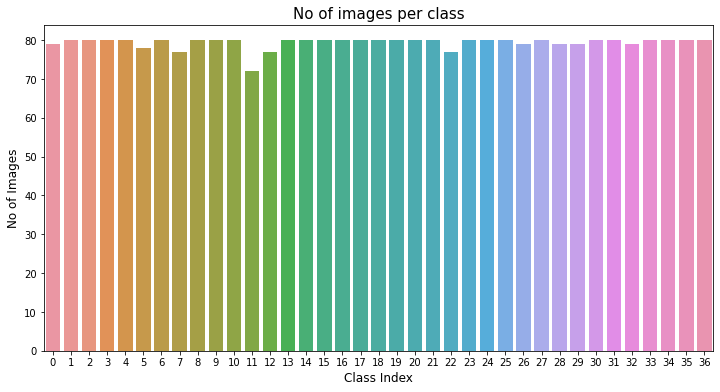

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(12,6))
sns.countplot(x=train_df["class_idx"])
axes.set_xlabel("Class Index",fontsize="large")
axes.set_ylabel("No of Images",fontsize="large")
axes.set_title("No of images per class",fontsize=15)
fig.show();

- The Average no of images per class 80

In [15]:
class_to_idx = train_df.groupby(by=["class_idx","class_label","species_label"]).size().to_frame().reset_index()
class_to_idx = class_to_idx.set_index("class_idx").loc[:,["class_label","species_label"]]
class_to_idx.head()

class_label species_label
class_idx                                         
0                         abyssinian           Cat
1                   american_bulldog           Dog
2          american_pit_bull_terrier           Dog
3                       basset_hound           Dog
4                             beagle           Dog

- Sample Images

In [16]:
def show_image(file):
    img_path,xml_path = validate_file(file)

    if img_path:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if xml_path:
        pt1, pt2 = get_BB(xml_path)
        img = cv2.rectangle(img, pt1, pt2, (0,255,0), 2)
    if img_path:
        breed = file.split("_")[0]
        species = "Cat" if breed[0].isupper() else "Dog"
        plt.title(f"Breed : {breed} | Species : {species}")

        plt.imshow(img)
        plt.axis('off')
        plt.show();
    else:
        pass

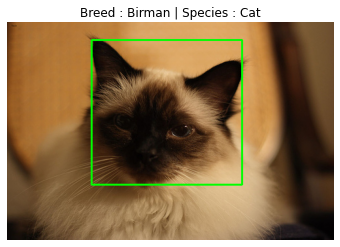

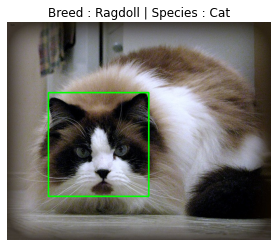

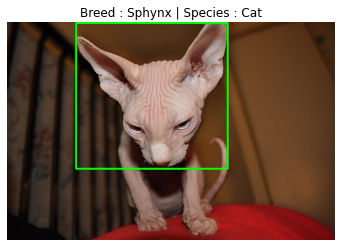

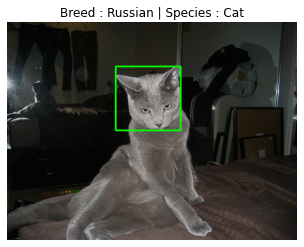

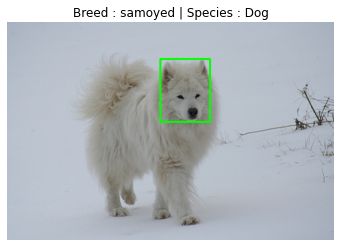

In [19]:
# fig, axes = plt.subplots(2, 3, figsize=(20,10))

for _ in range(5):
    file = train_df.sample(1)["image_name"].to_list()[0].split(".")[0]
    show_image(file)

In [20]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

def denormalize(images, means=[0.485, 0.456, 0.406], stds=[0.2023, 0.1994, 0.2010],device=get_device()):
    means = torch.tensor(means).reshape(1, 3, 1, 1).to(device)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1).to(device)
    return (images * stds + means)


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2  
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    iou = intersection / (box1_area + box2_area - intersection + 1e-6)

    return iou

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [21]:
class oxfordDataset(Dataset):
    def __init__(self,data_df,augmentations=None):
        self.data_df = data_df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self,idx):
        img_details = self.data_df.iloc[idx]

        img_path = img_details["image_path"]
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        class_label = torch.tensor(img_details["class_idx"], dtype=torch.long)
        xmin = img_details["xmin"]
        ymin = img_details["ymin"]
        xmax = img_details["xmax"]
        ymax = img_details["ymax"]

        bbox=[[xmin,ymin,xmax,ymax]]
        if self.augmentations:
            data = self.augmentations(image = image, bboxes = bbox, class_labels=[class_label])
            try: 
                image = data["image"]
                bboxes = torch.tensor(data["bboxes"][0], dtype=torch.float32)
                #class_label = data["class_labels"]
            except IndexError:
                print(img_path,idx)
                print(data)
        return (image.to(torch.float),class_label,bboxes)

In [23]:
train_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=int(IMG_SIZE * SCALE)),
        A.PadIfNeeded(
            min_height=int(IMG_SIZE * SCALE),
            min_width=int(IMG_SIZE * SCALE),
            border_mode=cv2.BORDER_CONSTANT,
        ),
        A.RandomCrop(width=IMG_SIZE, height=IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.Blur(p=0.1),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.2023, 0.1994, 0.2010], max_pixel_value=255),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"],),
)
val_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMG_SIZE),
        A.PadIfNeeded(
            min_height=IMG_SIZE, min_width=IMG_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.RandomCrop(width=IMG_SIZE, height=IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.2023, 0.1994, 0.2010], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']),
)

In [36]:
train_data = oxfordDataset(train_df,train_transforms)
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [37]:
val_data = oxfordDataset(val_df,val_transforms)
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE*2)

## Model RESNET

In [26]:
class ResidualBlock(nn.Module):
    def __init__(self,num_layers,in_channels,out_channels,identity_downsample=None,stride=1):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Not a Valid architecture'

        super(ResidualBlock,self).__init__()
        self.num_layers = num_layers
        self.expansion = 1 if self.num_layers < 50 else 4

        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                               kernel_size=1,stride=1,padding=0,bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=out_channels)

        if self.num_layers >= 50:

            self.conv2 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels,
                                   kernel_size=3,stride=stride,padding=1,bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.conv3 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels * self.expansion,
                                    kernel_size=1, stride=1, padding=0,bias=False)
            
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,
                                   kernel_size=3,stride=stride,padding=1,bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.conv3 = nn.Conv2d(in_channels=out_channels,out_channels=out_channels * self.expansion,
                                    kernel_size=3, stride=1, padding=1,bias=False)
            
        
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        self.downsample = identity_downsample

    def forward(self,x):
        identity = x
        if self.num_layers >= 50:
            x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        if self.downsample is not None and self.num_layers >= 50:
            identity = self.downsample(identity)
        x = self.relu(x + identity)
        return x

In [27]:
class ResNet(nn.Module):
    def __init__(self, 
                 num_layers, 
                 block, 
                 image_channels, 
                 num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '

        super(ResNet,self).__init__()

        self.expansion = 1 if num_layers < 50 else 4
        self.layers = self.get_layers(num_layers)

        ## num_out = ((num_in + 2*padding - kernal) / stride) + 1 
        ## conv1 layer
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=image_channels,out_channels=self.in_channels,
                               kernel_size=(7,7), stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=self.in_channels)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, self.layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, self.layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, self.layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, self.layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Linear(512 * self.expansion, num_classes)
    
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        return x

    def make_layers(self,num_layers,block,num_residual_blocks,intermediate_channels,stride):
        layers = []
        downsample = None
        if num_layers >= 50: 
            downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, 
                                                      kernel_size=1, stride=stride,bias=False),
                                                    nn.BatchNorm2d(intermediate_channels*self.expansion))
        
        layers.append(block(num_layers, self.in_channels, intermediate_channels, downsample, stride))

        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

    def get_layers(self,num_layers):
        self.layer_map = {
            18 : [2, 2, 2, 2],
            34 : [3, 4, 6, 3],
            50 : [3, 4, 6, 3],
            101: [3, 4, 23, 3],
            152: [3, 8, 36, 3]
        }
        return self.layer_map.get(num_layers,None)

In [29]:
class ObjLocModel(nn.Module):
    def __init__(self,num_layers,image_channels,num_classes,bb_points,block,pretrained):
        super(ObjLocModel,self).__init__()
        self.num_layers = num_layers
        self.image_channels = image_channels
        self.custom_resnet = block
        self.num_classes = num_classes
        self.bb_points = bb_points
        self.backbone= self.get_backbone(pretrained)
        self.in_features = 512 if num_layers < 50 else 2048

        self.fc_classification = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(in_features=1* 1* self.in_features, out_features=1 * 1 * self.in_features),
            nn.Dropout(p=0.2,inplace=True),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=num_classes)
        )
        
        self.fc_bounding_box = nn.Sequential(
            nn.Conv2d(in_channels=self.in_features,out_channels=2048,
                               kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=2048),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.Conv2d(in_channels=2048,out_channels=1024,
                               kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=1024),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.Conv2d(in_channels=1024,out_channels=self.in_features,
                      kernel_size=(3,3), stride=1, padding=1,bias=True),
            nn.BatchNorm2d(num_features=self.in_features),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),

            nn.AdaptiveAvgPool2d((1,1)),

            nn.Flatten(),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=1 * 1 * self.in_features),
            nn.Dropout(p=0.2,inplace=True),
            nn.Linear(in_features=1 * 1 * self.in_features, out_features=bb_points)
        )
    def forward(self,x):
        x = self.backbone(x)
        y_classification = self.fc_classification(x)
        y_bounding_box = self.fc_bounding_box(x)
        return y_classification,y_bounding_box
    
    def get_backbone(self,pretrained):
        if pretrained:
            weights,model = self.get_model_details(self.num_layers)
            pretrained_model = model(weights=weights.DEFAULT)
            for param in pretrained_model.parameters():
                param.requires_grad = False 
            layers = list(pretrained_model.children())[:8]
            backbone = nn.Sequential(*layers)
            return backbone
        else:
            backbone =  self.custom_resnet(num_layers=self.num_layers,
                                      block=ResidualBlock,
                                      image_channels=self.image_channels,
                                      num_classes=self.num_classes)
            for c in backbone.children():
                if isinstance(c, nn.Conv2d):
                    nn.init.xavier_uniform_(c.weight)
            return backbone
        
    def get_model_details(self,num_layers):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        resnet_models = {
            18 : [torchvision.models.ResNet18_Weights,torchvision.models.resnet18],
            34 : [torchvision.models.ResNet34_Weights,torchvision.models.resnet34],
            50 : [torchvision.models.ResNet50_Weights,torchvision.models.resnet50],
            101: [torchvision.models.ResNet101_Weights,torchvision.models.resnet101],
            152: [torchvision.models.ResNet152_Weights,torchvision.models.resnet152]
        }
        return resnet_models[num_layers]

In [30]:
model = ObjLocModel(num_layers=50,
                    image_channels=3,
                    num_classes=NUM_CLASSES,
                    bb_points=BOUNDING_BOX_POINTS,
                    block=ResNet,
                    pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [31]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjLocModel (ObjLocModel)                     [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (backbone)                       [32, 3, 224, 224]    [32, 2048, 7, 7]     --                   False
│    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (1)                        [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (2)                               [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (3)                          [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (4)                         [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56,

In [32]:
import torch
from tqdm.auto import tqdm
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               class_loss_fn: torch.nn.Module,
               bbox_loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               only_bbox : bool,
               grad_clip: float):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc , train_iou = 0, 0, 0

    # Loop through data loader data batches
    for batch_id, (X,y_label, y_bbox) in tqdm(enumerate(dataloader)):
        # Send data to target device
        (X,y_label, y_bbox) = X.to(device), y_label.to(device),y_bbox.to(device)

        # 1. Forward pass
        y_label_pred,y_bbox_pred = model(X)

        # 2. Calculate  and accumulate loss
        if only_bbox :
            loss = bbox_loss_fn(y_bbox_pred,y_bbox)
            train_loss += loss.item() 
        else:    
            label_loss = class_loss_fn(y_label_pred,y_label)
            bbox_loss = bbox_loss_fn(y_bbox_pred,y_bbox)
            loss = label_loss + bbox_loss
            train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        with torch.no_grad():
            y_pred_class = torch.argmax(torch.softmax(y_label_pred, dim=1), dim=1)
            train_acc += (y_pred_class == y_label).sum().item()/len(y_pred_class)
            train_iou += intersection_over_union(y_bbox_pred,y_bbox,"corners").sum().item()/len(y_bbox_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    scheduler.step(train_loss)
    train_acc = train_acc / len(dataloader)
    train_iou = train_iou / len(dataloader)
    return train_loss, train_acc,train_iou

In [33]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              class_loss_fn: torch.nn.Module,
              bbox_loss_fn:torch.nn.Module,
              device: torch.device,
              only_bbox: bool):
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc, test_iou = 0, 0,0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X,y_label, y_bbox) in tqdm(enumerate(dataloader)):
            # Send data to target device
            (X,y_label, y_bbox) = X.to(device), y_label.to(device),y_bbox.to(device)

        # 1. Forward pass
            y_label_pred,y_bbox_pred = model(X)

            # 2. Calculate and accumulate loss
            if only_bbox:
                loss = bbox_loss_fn(y_bbox_pred,y_bbox)
                test_loss += loss.item()
            else:
                label_loss = class_loss_fn(y_label_pred,y_label)
                bbox_loss = bbox_loss_fn(y_bbox_pred,y_bbox)
                loss = label_loss + bbox_loss
                test_loss += loss.item()

            # Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_label_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y_label).sum().item()/len(y_pred_class)
            test_iou += intersection_over_union(y_bbox_pred,y_bbox,'corners').sum().item()/len(y_bbox_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    test_iou = test_iou/ len(dataloader)
    return test_loss, test_acc, test_iou

In [38]:
# Define loss and optimizer and scheduler
seed_everything(42)
weight_decay = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
classification_loss_fn = nn.CrossEntropyLoss()
regression_loss_fn = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.4,patience=3,verbose=True)
ONLY_BBOX = False

In [39]:
torch.cuda.empty_cache()
GRAD_CLIP = 0.1
history = []
TOTAL_VAL_LOSS,TOTAL_VAL_IOU = 0,0
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc,train_iou = train_step(model,
                                                 train_dataloader,
                                                 classification_loss_fn,
                                                 regression_loss_fn,
                                                 optimizer,
                                                 device,
                                                 ONLY_BBOX,
                                                 GRAD_CLIP)
    print(f"{epoch} : train_loss {train_loss} | train_acc {train_acc} | train_iou {train_iou}")
    val_loss, val_acc, val_iou = test_step(model,
                                              val_dataloader,
                                              classification_loss_fn,
                                              regression_loss_fn,
                                              device,
                                              ONLY_BBOX)
    print(f"{epoch} : val_loss {val_loss} | test_acc {val_acc} | test_iou {val_iou}")
    if val_iou > TOTAL_VAL_IOU:
        TOTAL_VAL_IOU = val_iou
        save_model(model,"models","best-model-more-layers.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0 : train_loss 81.13713077876879 | train_acc 0.5876358695652174 | train_iou 0.1568089558476125


0it [00:00, ?it/s]

0 : val_loss 31.045663197835285 | test_acc 0.8265487938596491 | test_iou 0.2768185414243163
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

1 : train_loss 34.95013253585152 | train_acc 0.8402562111801243 | train_iou 0.2822068719575124


0it [00:00, ?it/s]

1 : val_loss 28.128780364990234 | test_acc 0.7926946271929824 | test_iou 0.3708015893634997
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

2 : train_loss 30.9474458279817 | train_acc 0.8711665372670808 | train_iou 0.32912793510263755


0it [00:00, ?it/s]

2 : val_loss 32.89341672261556 | test_acc 0.7891858552631579 | test_iou 0.34329680539014046


0it [00:00, ?it/s]

3 : train_loss 31.365896017655082 | train_acc 0.8504464285714286 | train_iou 0.3682023417320311


0it [00:00, ?it/s]

3 : val_loss 40.2142531077067 | test_acc 0.8156798245614035 | test_iou 0.3704700991249921


0it [00:00, ?it/s]

4 : train_loss 27.626442370207414 | train_acc 0.8792701863354037 | train_iou 0.427560366643882


0it [00:00, ?it/s]

4 : val_loss 25.14751402537028 | test_acc 0.8369106359649123 | test_iou 0.5024644955208427
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

5 : train_loss 22.624270273291547 | train_acc 0.8980978260869565 | train_iou 0.4971227391351084


0it [00:00, ?it/s]

5 : val_loss 31.238783836364746 | test_acc 0.8369654605263158 | test_iou 0.507805757982689
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

6 : train_loss 25.414001941680908 | train_acc 0.8963024068322981 | train_iou 0.49699233800913234


0it [00:00, ?it/s]

6 : val_loss 45.54821523030599 | test_acc 0.8438733552631579 | test_iou 0.3209505817346406


0it [00:00, ?it/s]

7 : train_loss 34.292981769727625 | train_acc 0.9078027950310559 | train_iou 0.35819670955957095


0it [00:00, ?it/s]

7 : val_loss 58.83299446105957 | test_acc 0.8457373903508771 | test_iou 0.1918923795746084


0it [00:00, ?it/s]

8 : train_loss 27.89194322668988 | train_acc 0.9120729813664596 | train_iou 0.4722357859244998


0it [00:00, ?it/s]

8 : val_loss 31.488062858581543 | test_acc 0.8530427631578948 | test_iou 0.5609991234645509
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

Epoch 00010: reducing learning rate of group 0 to 4.0000e-03.
9 : train_loss 26.174698456473973 | train_acc 0.9186238354037267 | train_iou 0.5069372274490618


0it [00:00, ?it/s]

9 : val_loss 33.52594788869222 | test_acc 0.8534402412280703 | test_iou 0.5404191578689375


0it [00:00, ?it/s]

10 : train_loss 16.148758846780527 | train_acc 0.9529794254658385 | train_iou 0.5953791381224341


0it [00:00, ?it/s]

10 : val_loss 30.78656005859375 | test_acc 0.8760827850877192 | test_iou 0.6261961324173108
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

11 : train_loss 13.188574542169986 | train_acc 0.9642857142857142 | train_iou 0.6129211165149759


0it [00:00, ?it/s]

11 : val_loss 25.32397206624349 | test_acc 0.8817434210526316 | test_iou 0.6151182127626319


0it [00:00, ?it/s]

12 : train_loss 12.742665622545326 | train_acc 0.9744759316770185 | train_iou 0.622610839812652


0it [00:00, ?it/s]

12 : val_loss 25.952429453531902 | test_acc 0.8799890350877192 | test_iou 0.6528987453694929
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

13 : train_loss 11.94124520343283 | train_acc 0.9692837732919254 | train_iou 0.6329342023186062


0it [00:00, ?it/s]

13 : val_loss 26.90480136871338 | test_acc 0.8777823464912281 | test_iou 0.6700184958022938
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

14 : train_loss 11.364952854488207 | train_acc 0.9747670807453417 | train_iou 0.6371311891523207


0it [00:00, ?it/s]

14 : val_loss 25.27790101369222 | test_acc 0.8817434210526316 | test_iou 0.6648071091426045


0it [00:00, ?it/s]

15 : train_loss 12.085413994996443 | train_acc 0.9751552795031055 | train_iou 0.6353727269987142


0it [00:00, ?it/s]

15 : val_loss 24.317638397216797 | test_acc 0.9000274122807017 | test_iou 0.6626966074893349


0it [00:00, ?it/s]

16 : train_loss 10.91331526507502 | train_acc 0.9790857919254659 | train_iou 0.6438634982390433


0it [00:00, ?it/s]

16 : val_loss 25.449952125549316 | test_acc 0.8839501096491228 | test_iou 0.6282418655721765


0it [00:00, ?it/s]

17 : train_loss 11.041390387908272 | train_acc 0.976077251552795 | train_iou 0.6387902857353969


0it [00:00, ?it/s]

17 : val_loss 22.790581544240315 | test_acc 0.9004797149122807 | test_iou 0.6738391734006113
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

18 : train_loss 11.36066159994706 | train_acc 0.9761743012422359 | train_iou 0.6357813856986738


0it [00:00, ?it/s]

18 : val_loss 21.33053684234619 | test_acc 0.8935169956140351 | test_iou 0.6669885437739523


0it [00:00, ?it/s]

19 : train_loss 10.610681253930796 | train_acc 0.9795225155279503 | train_iou 0.6536302833083254


0it [00:00, ?it/s]

19 : val_loss 22.33766492207845 | test_acc 0.8891584429824562 | test_iou 0.6632651830974378


0it [00:00, ?it/s]

20 : train_loss 11.203695203946983 | train_acc 0.9772418478260869 | train_iou 0.6389793783241177


0it [00:00, ?it/s]

20 : val_loss 23.21341323852539 | test_acc 0.8856496710526316 | test_iou 0.6600010070884437


0it [00:00, ?it/s]

21 : train_loss 11.252362230549688 | train_acc 0.9799592391304348 | train_iou 0.6345736188177736


0it [00:00, ?it/s]

21 : val_loss 24.351133982340496 | test_acc 0.8800438596491228 | test_iou 0.6508753929221839


0it [00:00, ?it/s]

22 : train_loss 10.429480044738106 | train_acc 0.9795225155279503 | train_iou 0.6583003479501476


0it [00:00, ?it/s]

22 : val_loss 22.20301882425944 | test_acc 0.8834978070175438 | test_iou 0.6704646271571778


0it [00:00, ?it/s]

23 : train_loss 10.313136681266453 | train_acc 0.9806385869565217 | train_iou 0.6473395606005414


0it [00:00, ?it/s]

23 : val_loss 20.136094729105633 | test_acc 0.8922149122807017 | test_iou 0.6944342897649397
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

24 : train_loss 10.959709053454192 | train_acc 0.9746700310559007 | train_iou 0.6707638933421662


0it [00:00, ?it/s]

24 : val_loss 21.007949829101562 | test_acc 0.8952165570175438 | test_iou 0.6777116824660384


0it [00:00, ?it/s]

25 : train_loss 11.060933196026346 | train_acc 0.9738451086956522 | train_iou 0.6541264993803841


0it [00:00, ?it/s]

25 : val_loss 23.244522412618 | test_acc 0.8891584429824562 | test_iou 0.6106011578911229


0it [00:00, ?it/s]

26 : train_loss 10.036030644955842 | train_acc 0.9781152950310559 | train_iou 0.6681485342683259


0it [00:00, ?it/s]

26 : val_loss 21.602890968322754 | test_acc 0.8822505482456141 | test_iou 0.6674793592670508


0it [00:00, ?it/s]

27 : train_loss 9.828264277914297 | train_acc 0.9802989130434783 | train_iou 0.67096025843798


0it [00:00, ?it/s]

27 : val_loss 20.61952527364095 | test_acc 0.8887609649122807 | test_iou 0.6955069693557002
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

28 : train_loss 10.35280154062354 | train_acc 0.9761257763975155 | train_iou 0.6754258186180399


0it [00:00, ?it/s]

28 : val_loss 22.210293134053547 | test_acc 0.8769325657894737 | test_iou 0.6527874663210752


0it [00:00, ?it/s]

29 : train_loss 11.254759954369586 | train_acc 0.9758346273291925 | train_iou 0.6447129497616928


0it [00:00, ?it/s]

29 : val_loss 34.285400390625 | test_acc 0.8556469298245615 | test_iou 0.6187651951062052


0it [00:00, ?it/s]

30 : train_loss 11.543522534163102 | train_acc 0.975397903726708 | train_iou 0.6395040092446049


0it [00:00, ?it/s]

30 : val_loss 24.4956693649292 | test_acc 0.8847998903508771 | test_iou 0.6753554803237581


0it [00:00, ?it/s]

Epoch 00032: reducing learning rate of group 0 to 1.6000e-03.
31 : train_loss 10.257314806399139 | train_acc 0.9805415372670808 | train_iou 0.661669885890084


0it [00:00, ?it/s]

31 : val_loss 20.889922777811687 | test_acc 0.8952165570175438 | test_iou 0.6775510060159783


0it [00:00, ?it/s]

32 : train_loss 8.538998230643895 | train_acc 0.9856851708074533 | train_iou 0.7013621128493955


0it [00:00, ?it/s]

32 : val_loss 17.901040077209473 | test_acc 0.8991228070175438 | test_iou 0.713921234273074
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

33 : train_loss 8.655669430027837 | train_acc 0.9826766304347826 | train_iou 0.7015624183305301


0it [00:00, ?it/s]

33 : val_loss 17.65224281946818 | test_acc 0.9034813596491228 | test_iou 0.7160331011864177
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

34 : train_loss 8.233758967855703 | train_acc 0.9866556677018634 | train_iou 0.6990734414654488


0it [00:00, ?it/s]

34 : val_loss 17.6306578318278 | test_acc 0.9134457236842105 | test_iou 0.7146632350327676


0it [00:00, ?it/s]

35 : train_loss 8.316117245218027 | train_acc 0.9894701086956522 | train_iou 0.6993415725897557


0it [00:00, ?it/s]

35 : val_loss 17.814351081848145 | test_acc 0.9052357456140351 | test_iou 0.7168261815581406
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

36 : train_loss 7.2878703863724414 | train_acc 0.9894215838509316 | train_iou 0.7208135294618073


0it [00:00, ?it/s]

36 : val_loss 17.47161293029785 | test_acc 0.9034813596491228 | test_iou 0.7213861067044108
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

37 : train_loss 7.929357808569203 | train_acc 0.9873835403726707 | train_iou 0.7127247341671346


0it [00:00, ?it/s]

37 : val_loss 16.88758659362793 | test_acc 0.9047834429824562 | test_iou 0.7283655252373009
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

38 : train_loss 7.607193604759548 | train_acc 0.9881114130434783 | train_iou 0.7156605529859199


0it [00:00, ?it/s]

38 : val_loss 18.101868470509846 | test_acc 0.8991228070175438 | test_iou 0.6941421723156646


0it [00:00, ?it/s]

39 : train_loss 7.70014008231785 | train_acc 0.9890819099378881 | train_iou 0.705494715560297


0it [00:00, ?it/s]

39 : val_loss 16.91302712758382 | test_acc 0.9116913377192982 | test_iou 0.7134485931772935


0it [00:00, ?it/s]

40 : train_loss 7.179748566254325 | train_acc 0.9921875 | train_iou 0.7098976083053564


0it [00:00, ?it/s]

40 : val_loss 18.087567965189617 | test_acc 0.9034265350877192 | test_iou 0.6850908739524976


0it [00:00, ?it/s]

41 : train_loss 7.425912463146707 | train_acc 0.9894701086956522 | train_iou 0.7176795938740606


0it [00:00, ?it/s]

41 : val_loss 16.73429282506307 | test_acc 0.9043311403508771 | test_iou 0.7208390911420186


0it [00:00, ?it/s]

42 : train_loss 7.078377205392589 | train_acc 0.9904891304347826 | train_iou 0.716275865431898


0it [00:00, ?it/s]

42 : val_loss 17.93974510828654 | test_acc 0.9034265350877192 | test_iou 0.722259882981317


0it [00:00, ?it/s]

43 : train_loss 7.243819682494454 | train_acc 0.9884510869565217 | train_iou 0.7189813445073476


0it [00:00, ?it/s]

43 : val_loss 17.042043209075928 | test_acc 0.9069353070175438 | test_iou 0.7245068377570102


0it [00:00, ?it/s]

44 : train_loss 7.24172017885291 | train_acc 0.9901494565217391 | train_iou 0.7228255475529973


0it [00:00, ?it/s]

44 : val_loss 16.26068687438965 | test_acc 0.9108963815789474 | test_iou 0.7401539593412165
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

45 : train_loss 6.716816207636958 | train_acc 0.9928668478260869 | train_iou 0.7315767927569633


0it [00:00, ?it/s]

45 : val_loss 17.579320430755615 | test_acc 0.9108415570175438 | test_iou 0.7180145619208352


0it [00:00, ?it/s]

46 : train_loss 6.954571381859157 | train_acc 0.9932065217391305 | train_iou 0.7228497936858894


0it [00:00, ?it/s]

46 : val_loss 16.721345901489258 | test_acc 0.9125959429824562 | test_iou 0.736707434842461


0it [00:00, ?it/s]

47 : train_loss 6.815662259640901 | train_acc 0.9907802795031055 | train_iou 0.7321888049196753


0it [00:00, ?it/s]

47 : val_loss 16.763019402821858 | test_acc 0.9030290570175438 | test_iou 0.7093768588283605


0it [00:00, ?it/s]

48 : train_loss 6.541054051855336 | train_acc 0.9921389751552795 | train_iou 0.73127898222171


0it [00:00, ?it/s]

48 : val_loss 16.577240149180096 | test_acc 0.9091419956140351 | test_iou 0.731517070322706


0it [00:00, ?it/s]

49 : train_loss 7.06016931326493 | train_acc 0.9915081521739131 | train_iou 0.7168309024031858


0it [00:00, ?it/s]

49 : val_loss 18.0391681989034 | test_acc 0.8895559210526316 | test_iou 0.7312513708022603


0it [00:00, ?it/s]

50 : train_loss 6.575811707455179 | train_acc 0.993546195652174 | train_iou 0.7322320875173771


0it [00:00, ?it/s]

50 : val_loss 15.628378868103027 | test_acc 0.9143503289473683 | test_iou 0.7418234656777298
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

51 : train_loss 6.586883482725724 | train_acc 0.9894215838509316 | train_iou 0.7359815852612442


0it [00:00, ?it/s]

51 : val_loss 14.941707611083984 | test_acc 0.9034813596491228 | test_iou 0.7423203706741334
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

52 : train_loss 6.2894032105155615 | train_acc 0.9918478260869565 | train_iou 0.7417158112392662


0it [00:00, ?it/s]

52 : val_loss 15.602982680002848 | test_acc 0.9082373903508771 | test_iou 0.7357851666316652


0it [00:00, ?it/s]

53 : train_loss 6.585438479547915 | train_acc 0.9904891304347826 | train_iou 0.7380672356356746


0it [00:00, ?it/s]

53 : val_loss 16.3457350730896 | test_acc 0.8995202850877192 | test_iou 0.7236465979040715


0it [00:00, ?it/s]

54 : train_loss 7.381240316059278 | train_acc 0.9928668478260869 | train_iou 0.7137030080793807


0it [00:00, ?it/s]

54 : val_loss 17.451112111409504 | test_acc 0.8913103070175438 | test_iou 0.7145554761091869


0it [00:00, ?it/s]

55 : train_loss 6.722915017086526 | train_acc 0.9911684782608695 | train_iou 0.7305226150136557


0it [00:00, ?it/s]

55 : val_loss 15.983495871225992 | test_acc 0.9095942982456141 | test_iou 0.7154223203659057


0it [00:00, ?it/s]

Epoch 00057: reducing learning rate of group 0 to 6.4000e-04.
56 : train_loss 7.00163111479386 | train_acc 0.9890819099378881 | train_iou 0.7237756689142737


0it [00:00, ?it/s]

56 : val_loss 15.517430941263834 | test_acc 0.9112938596491228 | test_iou 0.7204928924117172


0it [00:00, ?it/s]

57 : train_loss 6.216958263646001 | train_acc 0.9914596273291925 | train_iou 0.7409185365490292


0it [00:00, ?it/s]

57 : val_loss 14.583568255106607 | test_acc 0.9117461622807017 | test_iou 0.7337436959408877


0it [00:00, ?it/s]

58 : train_loss 6.028002728586611 | train_acc 0.9952445652173914 | train_iou 0.7443903434720839


0it [00:00, ?it/s]

58 : val_loss 14.3592742284139 | test_acc 0.9200109649122807 | test_iou 0.7372849665190043


0it [00:00, ?it/s]

59 : train_loss 5.2881560740263565 | train_acc 0.9972826086956522 | train_iou 0.7640660760565574


0it [00:00, ?it/s]

59 : val_loss 14.576316197713217 | test_acc 0.9130482456140351 | test_iou 0.7486024061838785
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

60 : train_loss 5.447627523671025 | train_acc 0.992478649068323 | train_iou 0.7654260111891705


0it [00:00, ?it/s]

60 : val_loss 15.192302385965982 | test_acc 0.9069353070175438 | test_iou 0.7388822624557897


0it [00:00, ?it/s]

61 : train_loss 5.553319195042485 | train_acc 0.992090450310559 | train_iou 0.7633183924307735


0it [00:00, ?it/s]

61 : val_loss 14.866591612497965 | test_acc 0.9060855263157895 | test_iou 0.7376097759656739


0it [00:00, ?it/s]

62 : train_loss 5.255125092423481 | train_acc 0.9945652173913043 | train_iou 0.7681282549541188


0it [00:00, ?it/s]

62 : val_loss 14.082573095957438 | test_acc 0.9091419956140351 | test_iou 0.7525066448931108
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

63 : train_loss 5.233626635178275 | train_acc 0.9962635869565217 | train_iou 0.7659508343438924


0it [00:00, ?it/s]

63 : val_loss 13.949786186218262 | test_acc 0.9086896929824562 | test_iou 0.7572295375037612
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

64 : train_loss 5.275446181711943 | train_acc 0.9945652173913043 | train_iou 0.7691965508535041


0it [00:00, ?it/s]

64 : val_loss 14.030407746632894 | test_acc 0.9086896929824562 | test_iou 0.7548745718964359


0it [00:00, ?it/s]

65 : train_loss 5.24380988660066 | train_acc 0.9945652173913043 | train_iou 0.7671083572858608


0it [00:00, ?it/s]

65 : val_loss 14.329240004221598 | test_acc 0.9099917763157895 | test_iou 0.7482955822819157


0it [00:00, ?it/s]

66 : train_loss 5.2928306641786 | train_acc 0.9948078416149069 | train_iou 0.7666693142852428


0it [00:00, ?it/s]

66 : val_loss 14.547849814097086 | test_acc 0.9069353070175438 | test_iou 0.7495142773578042


0it [00:00, ?it/s]

67 : train_loss 5.168644531913426 | train_acc 0.9949048913043478 | train_iou 0.7706266308423154


0it [00:00, ?it/s]

67 : val_loss 13.956710974375406 | test_acc 0.9056332236842105 | test_iou 0.7516378741515309


0it [00:00, ?it/s]

68 : train_loss 5.206373012584189 | train_acc 0.9932065217391305 | train_iou 0.7689541746740756


0it [00:00, ?it/s]

68 : val_loss 13.958853244781494 | test_acc 0.9043311403508771 | test_iou 0.7506509810163263


0it [00:00, ?it/s]

69 : train_loss 5.148587828097136 | train_acc 0.9938858695652174 | train_iou 0.7729216656699683


0it [00:00, ?it/s]

69 : val_loss 13.895534833272299 | test_acc 0.9047834429824562 | test_iou 0.7523153812216039


0it [00:00, ?it/s]

70 : train_loss 5.2997694689294566 | train_acc 0.9937888198757764 | train_iou 0.7687347777511763


0it [00:00, ?it/s]

70 : val_loss 13.155602296193441 | test_acc 0.9156524122807017 | test_iou 0.7464795178488681


0it [00:00, ?it/s]

71 : train_loss 5.0507450362910395 | train_acc 0.9952445652173914 | train_iou 0.7738511786327599


0it [00:00, ?it/s]

71 : val_loss 13.516083558400473 | test_acc 0.9082373903508771 | test_iou 0.7512701869010926


0it [00:00, ?it/s]

72 : train_loss 5.096873449242634 | train_acc 0.9904891304347826 | train_iou 0.7815350236729806


0it [00:00, ?it/s]

72 : val_loss 13.929509480794271 | test_acc 0.9117461622807017 | test_iou 0.7439370957382939


0it [00:00, ?it/s]

73 : train_loss 5.048994090246118 | train_acc 0.9952445652173914 | train_iou 0.7733316328954992


0it [00:00, ?it/s]

73 : val_loss 13.043389956156412 | test_acc 0.9138980263157895 | test_iou 0.7509423444145605


0it [00:00, ?it/s]

74 : train_loss 5.1092907967774766 | train_acc 0.9934976708074533 | train_iou 0.7740681663803433


0it [00:00, ?it/s]

74 : val_loss 13.354914824167887 | test_acc 0.9125959429824562 | test_iou 0.7558397343284206


0it [00:00, ?it/s]

75 : train_loss 5.019825220108032 | train_acc 0.9942255434782609 | train_iou 0.7748278475696256


0it [00:00, ?it/s]

75 : val_loss 12.819825331370035 | test_acc 0.9178591008771929 | test_iou 0.7560058928372567


0it [00:00, ?it/s]

76 : train_loss 4.959541984226393 | train_acc 0.9952445652173914 | train_iou 0.7767769237112555


0it [00:00, ?it/s]

76 : val_loss 13.535992622375488 | test_acc 0.9104440789473683 | test_iou 0.7534784230223873


0it [00:00, ?it/s]

77 : train_loss 5.2347684424856435 | train_acc 0.9932065217391305 | train_iou 0.7693444732923685


0it [00:00, ?it/s]

77 : val_loss 14.285552342732748 | test_acc 0.9069901315789474 | test_iou 0.7550475800246522


0it [00:00, ?it/s]

78 : train_loss 4.85797493354134 | train_acc 0.9962150621118012 | train_iou 0.7795760640816659


0it [00:00, ?it/s]

78 : val_loss 12.935262044270834 | test_acc 0.9091419956140351 | test_iou 0.757481465005038
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

79 : train_loss 4.892692685127258 | train_acc 0.9921389751552795 | train_iou 0.7836264318190745


0it [00:00, ?it/s]

79 : val_loss 12.577490011850992 | test_acc 0.9125959429824562 | test_iou 0.7603034954322011
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

80 : train_loss 4.838515395703523 | train_acc 0.9928668478260869 | train_iou 0.7820260558069122


0it [00:00, ?it/s]

80 : val_loss 12.681788126627604 | test_acc 0.9047834429824562 | test_iou 0.7593698139776263


0it [00:00, ?it/s]

81 : train_loss 4.815496398055035 | train_acc 0.9959239130434783 | train_iou 0.7812234570521006


0it [00:00, ?it/s]

81 : val_loss 12.614299297332764 | test_acc 0.9187088815789474 | test_iou 0.7596225706108829


0it [00:00, ?it/s]

82 : train_loss 4.8864520477212 | train_acc 0.9918478260869565 | train_iou 0.7847270239954409


0it [00:00, ?it/s]

82 : val_loss 12.70167096455892 | test_acc 0.9191611842105263 | test_iou 0.7533086986918199


0it [00:00, ?it/s]

83 : train_loss 4.638125590656115 | train_acc 0.9949048913043478 | train_iou 0.7867479346553732


0it [00:00, ?it/s]

83 : val_loss 12.711590131123861 | test_acc 0.9134457236842105 | test_iou 0.755832635833506


0it [00:00, ?it/s]

84 : train_loss 4.723434069882268 | train_acc 0.9951960403726707 | train_iou 0.784385867740797


0it [00:00, ?it/s]

84 : val_loss 12.781360626220703 | test_acc 0.9182565789473683 | test_iou 0.7564169647400839


0it [00:00, ?it/s]

85 : train_loss 4.657992720603943 | train_acc 0.9962150621118012 | train_iou 0.7845216297214815


0it [00:00, ?it/s]

85 : val_loss 12.954051653544107 | test_acc 0.9195586622807017 | test_iou 0.7572525686339328


0it [00:00, ?it/s]

86 : train_loss 4.727062463760376 | train_acc 0.9942255434782609 | train_iou 0.7841628906519517


0it [00:00, ?it/s]

86 : val_loss 12.278475284576416 | test_acc 0.9143503289473683 | test_iou 0.7585379523143434


0it [00:00, ?it/s]

Epoch 00088: reducing learning rate of group 0 to 2.5600e-04.
87 : train_loss 4.700935327488443 | train_acc 0.9945166925465838 | train_iou 0.7831381461264925


0it [00:00, ?it/s]

87 : val_loss 12.836397806803385 | test_acc 0.9078399122807017 | test_iou 0.7576990999673542


0it [00:00, ?it/s]

88 : train_loss 4.570121200188346 | train_acc 0.9959239130434783 | train_iou 0.7896837007184946


0it [00:00, ?it/s]

88 : val_loss 12.6986083984375 | test_acc 0.9086896929824562 | test_iou 0.7577653928806907


0it [00:00, ?it/s]

89 : train_loss 4.441239460654881 | train_acc 0.9952445652173914 | train_iou 0.7957725315730764


0it [00:00, ?it/s]

89 : val_loss 12.58541981379191 | test_acc 0.9230674342105263 | test_iou 0.7630077191612177
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

90 : train_loss 4.339774530866872 | train_acc 0.9959239130434783 | train_iou 0.7955704757145472


0it [00:00, ?it/s]

90 : val_loss 12.371209621429443 | test_acc 0.9178591008771929 | test_iou 0.7627300954701607


0it [00:00, ?it/s]

91 : train_loss 4.5960139709970225 | train_acc 0.9938858695652174 | train_iou 0.7922081528983501


0it [00:00, ?it/s]

91 : val_loss 12.894261519114176 | test_acc 0.9191611842105263 | test_iou 0.759434256741875


0it [00:00, ?it/s]

92 : train_loss 4.362347079359966 | train_acc 0.9966032608695652 | train_iou 0.7947352350868794


0it [00:00, ?it/s]

92 : val_loss 12.276839097340902 | test_acc 0.9204632675438597 | test_iou 0.7633100237762719
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

93 : train_loss 4.383877209995104 | train_acc 0.9949048913043478 | train_iou 0.7962135493014911


0it [00:00, ?it/s]

93 : val_loss 12.492036660512289 | test_acc 0.9191611842105263 | test_iou 0.7578309241094088


0it [00:00, ?it/s]

94 : train_loss 4.163843595463296 | train_acc 0.9979619565217391 | train_iou 0.7998305274092633


0it [00:00, ?it/s]

94 : val_loss 12.358018239339193 | test_acc 0.9165570175438597 | test_iou 0.760447714516991


0it [00:00, ?it/s]

95 : train_loss 4.136241674423218 | train_acc 0.9969429347826086 | train_iou 0.8020673564502172


0it [00:00, ?it/s]

95 : val_loss 12.56617546081543 | test_acc 0.9204632675438597 | test_iou 0.7564953119085546


0it [00:00, ?it/s]

96 : train_loss 4.26521210566811 | train_acc 0.9976222826086957 | train_iou 0.7977252023190445


0it [00:00, ?it/s]

96 : val_loss 12.227888107299805 | test_acc 0.9165570175438597 | test_iou 0.7644437560909673
[INFO] Saving model to: models/best-model-more-layers.pth


0it [00:00, ?it/s]

97 : train_loss 4.1633190383081855 | train_acc 0.9972826086956522 | train_iou 0.8028819175980846


0it [00:00, ?it/s]

97 : val_loss 12.538779258728027 | test_acc 0.9169544956140351 | test_iou 0.7622807068782941


0it [00:00, ?it/s]

98 : train_loss 4.162184357643127 | train_acc 0.9979619565217391 | train_iou 0.7981155883081211


0it [00:00, ?it/s]

98 : val_loss 12.663612047831217 | test_acc 0.9187088815789474 | test_iou 0.7623716093991932


0it [00:00, ?it/s]

Epoch 00100: reducing learning rate of group 0 to 1.0240e-04.
99 : train_loss 4.27395891106647 | train_acc 0.9952445652173914 | train_iou 0.799819644008364


0it [00:00, ?it/s]

99 : val_loss 12.724342664082846 | test_acc 0.9178591008771929 | test_iou 0.7637252684225116


In [41]:
save_model(model,"models","last_model.pth")

[INFO] Saving model to: models/last_model.pth


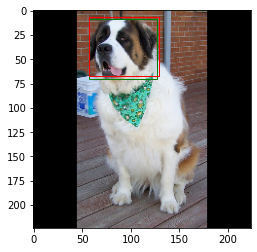

In [51]:
img,label,box = next(iter(val_dataloader))
img,label,box = img.to(device),label.to(device),box.to(device)
idx = 25 
with torch.no_grad():
    y_label,y_bbox = model(img)
img = denormalize(img[idx]).squeeze(axis=0).permute(1,2,0)
xmin,ymin,width,height = box[idx][0].cpu().numpy().astype(np.uint8),box[idx][1].cpu().numpy().astype(np.uint8),(box[idx][2]-box[idx][0]).cpu().numpy().astype(np.uint8),(box[idx][3]-box[idx][1]).cpu().numpy().astype(np.uint8)
fig,ax = plt.subplots(1)
ax.imshow(img.cpu())
rect = patches.Rectangle((xmin,ymin),width,height,linewidth=1,edgecolor='g',facecolor='none')
ax.add_patch(rect)
xmin,ymin,width,height = y_bbox[idx][0].cpu().numpy().astype(np.uint8),y_bbox[idx][1].cpu().numpy().astype(np.uint8),(y_bbox[idx][2]-y_bbox[idx][0]).cpu().numpy().astype(np.uint8),(y_bbox[idx][3]-y_bbox[idx][1]).cpu().numpy().astype(np.uint8)
rect = patches.Rectangle((xmin,ymin),width,height,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [43]:
res = 0
for images,labels,bboxes in val_dataloader:
    with torch.no_grad():
        y_labels,y_bboxes = model(images.to(device))

In [44]:
labels

tensor([27, 31,  1,  6, 25, 22,  2, 21, 30, 25, 24,  4, 13,  3, 31,  3, 10,  4,
        36,  7, 17, 26,  1, 18,  4,  9, 36, 22,  2, 29,  2, 20, 31, 34,  1, 22,
        16, 35, 13, 25, 18, 33, 31, 18,  7, 18, 27,  5, 36, 33, 22, 16, 27, 36,
        20,  6, 10, 29, 21, 17,  0, 24, 31, 32, 14,  5, 10,  6, 28, 26, 23, 16,
        16, 22,  2, 33, 34,  1, 19,  4,  1,  0, 30,  9, 17,  0,  4,  9, 31, 33,
         7, 20,  8, 20,  5])

In [45]:
y_labels.argmax(dim=1)

tensor([27, 31,  1,  6, 25, 22,  2, 21, 30, 25, 24,  4, 13,  3, 31,  3,  5,  4,
        36,  7, 17, 29,  1, 18,  4,  9, 36, 22,  2, 29,  2, 20, 31, 34,  1, 22,
        16, 35, 13, 25, 18, 33, 31, 18,  7, 18,  9,  5, 36, 33, 22, 16, 27, 36,
        20,  6, 10, 29, 21, 17,  0, 24, 31, 32, 14,  5, 21,  6, 28, 26, 23, 16,
        16, 22,  2, 33, 34,  1, 19,  4,  1,  9, 30,  9, 17,  0,  4,  9, 31, 33,
         7, 26,  8, 20,  5], device='cuda:0')

In [47]:
def freeze_classification(input_model):
    for param in input_model.fc_classification.parameters():
        param.requires_grad = False

In [48]:
freeze_classification(model)

In [49]:
ONLY_BBOX = True
for epoch in tqdm(range(50)):
    train_loss, train_acc,train_iou = train_step(model,
                                                 train_dataloader,
                                                 classification_loss_fn,
                                                 regression_loss_fn,
                                                 optimizer,
                                                 device,
                                                 ONLY_BBOX,
                                                 GRAD_CLIP)
    print(f"{epoch} : train_loss {train_loss} | train_acc {train_acc} | train_iou {train_iou}")
    val_loss, val_acc, val_iou = test_step(model,
                                              val_dataloader,
                                              classification_loss_fn,
                                              regression_loss_fn,
                                              device,
                                              ONLY_BBOX)
    print(f"{epoch} : val_loss {val_loss} | val_acc {val_acc} | val_iou {val_iou}")
    if val_iou > TOTAL_VAL_IOU:
        TOTAL_VAL_IOU = val_iou
        save_model(model,"models","best_model.pth")

  0%|          | 0/50 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0 : train_loss 3.911676717841107 | train_acc 0.9959239130434783 | train_iou 0.8076125703613211


0it [00:00, ?it/s]

0 : val_loss 4.724977493286133 | val_acc 0.9217653508771929 | val_iou 0.7628714790469721


0it [00:00, ?it/s]

1 : train_loss 3.832233558530393 | train_acc 0.9966032608695652 | train_iou 0.8097314590252706


0it [00:00, ?it/s]

1 : val_loss 4.576960802078247 | val_acc 0.9191611842105263 | val_iou 0.7680803091902483
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

2 : train_loss 3.830155662868334 | train_acc 0.9962635869565217 | train_iou 0.8097667875497238


0it [00:00, ?it/s]

2 : val_loss 4.635020732879639 | val_acc 0.9191611842105263 | val_iou 0.7665426367207577


0it [00:00, ?it/s]

3 : train_loss 3.9054985461027725 | train_acc 0.9982531055900621 | train_iou 0.8051541482809909


0it [00:00, ?it/s]

3 : val_loss 4.548077901204427 | val_acc 0.9191611842105263 | val_iou 0.7698225338208048
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

4 : train_loss 3.6879406286322554 | train_acc 0.9966032608695652 | train_iou 0.8143598478032936


0it [00:00, ?it/s]

4 : val_loss 4.5693856080373125 | val_acc 0.9191611842105263 | val_iou 0.768495717069559


0it [00:00, ?it/s]

5 : train_loss 3.855541306993236 | train_acc 0.9969429347826086 | train_iou 0.809002100125603


0it [00:00, ?it/s]

5 : val_loss 4.5672439734141035 | val_acc 0.9204632675438597 | val_iou 0.769076633976217


0it [00:00, ?it/s]

6 : train_loss 3.7825361334759258 | train_acc 0.9976222826086957 | train_iou 0.8111405728026206


0it [00:00, ?it/s]

6 : val_loss 4.623474756876628 | val_acc 0.9148026315789474 | val_iou 0.7662189007851116


0it [00:00, ?it/s]

7 : train_loss 3.8359885889550913 | train_acc 0.9949048913043478 | train_iou 0.8089380926967408


0it [00:00, ?it/s]

7 : val_loss 4.669034719467163 | val_acc 0.9213130482456141 | val_iou 0.764724256072128


0it [00:00, ?it/s]

Epoch 00109: reducing learning rate of group 0 to 4.0960e-05.
8 : train_loss 3.848356475000796 | train_acc 0.9952445652173914 | train_iou 0.8090382560809948


0it [00:00, ?it/s]

8 : val_loss 4.59954309463501 | val_acc 0.9204632675438597 | val_iou 0.767435363928477


0it [00:00, ?it/s]

9 : train_loss 3.802312907965287 | train_acc 0.9941770186335404 | train_iou 0.8088392145145014


0it [00:00, ?it/s]

9 : val_loss 4.580459912618001 | val_acc 0.9165570175438597 | val_iou 0.7678161345030131


0it [00:00, ?it/s]

10 : train_loss 3.666433246239372 | train_acc 0.9983016304347826 | train_iou 0.8163707074911698


0it [00:00, ?it/s]

10 : val_loss 4.551675319671631 | val_acc 0.9204632675438597 | val_iou 0.7695053191561447


0it [00:00, ?it/s]

11 : train_loss 3.7458832523097163 | train_acc 0.9949048913043478 | train_iou 0.8118166625499725


0it [00:00, ?it/s]

11 : val_loss 4.573604504267375 | val_acc 0.9209155701754387 | val_iou 0.768518951273801


0it [00:00, ?it/s]

12 : train_loss 3.659401852151622 | train_acc 0.9949048913043478 | train_iou 0.8167340681419609


0it [00:00, ?it/s]

12 : val_loss 4.571494023005168 | val_acc 0.9187088815789474 | val_iou 0.7686469451377267


0it [00:00, ?it/s]

13 : train_loss 3.7710637061492256 | train_acc 0.9955842391304348 | train_iou 0.8112637596841185


0it [00:00, ?it/s]

13 : val_loss 4.568086465199788 | val_acc 0.9235197368421053 | val_iou 0.7693811588120042


0it [00:00, ?it/s]

14 : train_loss 3.7947884538899297 | train_acc 0.9952445652173914 | train_iou 0.810746539083327


0it [00:00, ?it/s]

14 : val_loss 4.578163464864095 | val_acc 0.9191611842105263 | val_iou 0.7690512413518471


0it [00:00, ?it/s]

15 : train_loss 3.8185123723486196 | train_acc 0.9966032608695652 | train_iou 0.8100137904934261


0it [00:00, ?it/s]

15 : val_loss 4.537033319473267 | val_acc 0.9178591008771929 | val_iou 0.7699489386458146
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

Epoch 00117: reducing learning rate of group 0 to 1.6384e-05.
16 : train_loss 3.854439217111339 | train_acc 0.9952445652173914 | train_iou 0.8088795189161478


0it [00:00, ?it/s]

16 : val_loss 4.540896813074748 | val_acc 0.9248218201754387 | val_iou 0.7703625354850501
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

17 : train_loss 3.76143145042917 | train_acc 0.9959239130434783 | train_iou 0.8114467226200223


0it [00:00, ?it/s]

17 : val_loss 4.519593318303426 | val_acc 0.9178591008771929 | val_iou 0.770354705212409


0it [00:00, ?it/s]

18 : train_loss 3.6553349080293076 | train_acc 0.9934976708074533 | train_iou 0.8150352065607628


0it [00:00, ?it/s]

18 : val_loss 4.528430938720703 | val_acc 0.9191611842105263 | val_iou 0.7703877283815751
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

19 : train_loss 3.7339514701262764 | train_acc 0.9942255434782609 | train_iou 0.8129015929580475


0it [00:00, ?it/s]

19 : val_loss 4.55905810991923 | val_acc 0.9156524122807017 | val_iou 0.769626756090867


0it [00:00, ?it/s]

20 : train_loss 3.7091461679209834 | train_acc 0.9944681677018634 | train_iou 0.8149740355355399


0it [00:00, ?it/s]

20 : val_loss 4.529955625534058 | val_acc 0.9217653508771929 | val_iou 0.7706855760331739
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

21 : train_loss 3.802334251611129 | train_acc 0.9959239130434783 | train_iou 0.8101576538930028


0it [00:00, ?it/s]

21 : val_loss 4.52510929107666 | val_acc 0.9191611842105263 | val_iou 0.7697933519095704


0it [00:00, ?it/s]

Epoch 00123: reducing learning rate of group 0 to 6.5536e-06.
22 : train_loss 3.662204493647036 | train_acc 0.9951960403726707 | train_iou 0.8159722472940172


0it [00:00, ?it/s]

22 : val_loss 4.564797560373942 | val_acc 0.9261239035087719 | val_iou 0.7697967104744493


0it [00:00, ?it/s]

23 : train_loss 3.5941047512966655 | train_acc 0.9955357142857142 | train_iou 0.8191550146348728


0it [00:00, ?it/s]

23 : val_loss 4.531332333882649 | val_acc 0.9209155701754387 | val_iou 0.7706217017090111


0it [00:00, ?it/s]

24 : train_loss 3.686326125393743 | train_acc 0.9955842391304348 | train_iou 0.8145687132148269


0it [00:00, ?it/s]

24 : val_loss 4.531426986058553 | val_acc 0.9200109649122807 | val_iou 0.771038636408354
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

25 : train_loss 3.5575836119444473 | train_acc 0.9966032608695652 | train_iou 0.8199060910977193


0it [00:00, ?it/s]

25 : val_loss 4.513442675272624 | val_acc 0.9191611842105263 | val_iou 0.7712496713588113
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

26 : train_loss 3.744880821393884 | train_acc 0.998641304347826 | train_iou 0.8131997705616566


0it [00:00, ?it/s]

26 : val_loss 4.531050443649292 | val_acc 0.9235197368421053 | val_iou 0.7708984327943701


0it [00:00, ?it/s]

27 : train_loss 3.633394049561542 | train_acc 0.9966032608695652 | train_iou 0.817223377664637


0it [00:00, ?it/s]

27 : val_loss 4.52176038424174 | val_acc 0.9217653508771929 | val_iou 0.7710246582825979


0it [00:00, ?it/s]

28 : train_loss 3.67520460875138 | train_acc 0.9959239130434783 | train_iou 0.8146269782359555


0it [00:00, ?it/s]

28 : val_loss 4.511565526326497 | val_acc 0.9148026315789474 | val_iou 0.7712853684759976
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

Epoch 00130: reducing learning rate of group 0 to 2.6214e-06.
29 : train_loss 3.5851704556009043 | train_acc 0.9945652173913043 | train_iou 0.8183200503728405


0it [00:00, ?it/s]

29 : val_loss 4.526577790578206 | val_acc 0.9187088815789474 | val_iou 0.7706122270801611


0it [00:00, ?it/s]

30 : train_loss 3.7465079038039497 | train_acc 0.9958753881987576 | train_iou 0.8120064107897859


0it [00:00, ?it/s]

30 : val_loss 4.552397966384888 | val_acc 0.9222176535087719 | val_iou 0.7696350159352287


0it [00:00, ?it/s]

31 : train_loss 3.7314821067063706 | train_acc 0.9938858695652174 | train_iou 0.8143696759058081


0it [00:00, ?it/s]

31 : val_loss 4.499751011530559 | val_acc 0.9204632675438597 | val_iou 0.7717224066717584
[INFO] Saving model to: models/best_model.pth


0it [00:00, ?it/s]

32 : train_loss 3.6347360248151035 | train_acc 0.9969429347826086 | train_iou 0.8168450519905327


0it [00:00, ?it/s]

32 : val_loss 4.571788549423218 | val_acc 0.9187088815789474 | val_iou 0.7691152274608611


0it [00:00, ?it/s]

Epoch 00134: reducing learning rate of group 0 to 1.0486e-06.
33 : train_loss 3.6451726685399595 | train_acc 0.9972826086956522 | train_iou 0.8169627732001475


0it [00:00, ?it/s]

33 : val_loss 4.5090164343516035 | val_acc 0.9204632675438597 | val_iou 0.7711051337551652


0it [00:00, ?it/s]

34 : train_loss 3.612344627795012 | train_acc 0.9962635869565217 | train_iou 0.817757785320282


0it [00:00, ?it/s]

34 : val_loss 4.523723125457764 | val_acc 0.9204632675438597 | val_iou 0.7707123352770219


0it [00:00, ?it/s]

35 : train_loss 3.650300305822621 | train_acc 0.9979619565217391 | train_iou 0.8164165399459578


0it [00:00, ?it/s]

35 : val_loss 4.558521906534831 | val_acc 0.9204632675438597 | val_iou 0.7693776969324079


0it [00:00, ?it/s]

36 : train_loss 3.603266716003418 | train_acc 0.9952445652173914 | train_iou 0.818236675136578


0it [00:00, ?it/s]

36 : val_loss 4.515015284220378 | val_acc 0.9209155701754387 | val_iou 0.7707415108095136


0it [00:00, ?it/s]

Epoch 00138: reducing learning rate of group 0 to 4.1943e-07.
37 : train_loss 3.7776552646056465 | train_acc 0.9955842391304348 | train_iou 0.8112300341914159


0it [00:00, ?it/s]

37 : val_loss 4.544458627700806 | val_acc 0.9222176535087719 | val_iou 0.770470023259782


0it [00:00, ?it/s]

38 : train_loss 3.6087066971737407 | train_acc 0.9958753881987576 | train_iou 0.8180278110207978


0it [00:00, ?it/s]

38 : val_loss 4.537639856338501 | val_acc 0.9187088815789474 | val_iou 0.7702382545722158


0it [00:00, ?it/s]

39 : train_loss 3.648521521817083 | train_acc 0.9955842391304348 | train_iou 0.8159468294300648


0it [00:00, ?it/s]

39 : val_loss 4.534793376922607 | val_acc 0.9204632675438597 | val_iou 0.7703476320233261


0it [00:00, ?it/s]

40 : train_loss 3.6102611500283945 | train_acc 0.9945652173913043 | train_iou 0.8177378727412372


0it [00:00, ?it/s]

40 : val_loss 4.553679466247559 | val_acc 0.9191611842105263 | val_iou 0.7696574063677537


0it [00:00, ?it/s]

Epoch 00142: reducing learning rate of group 0 to 1.6777e-07.
41 : train_loss 3.599236519440361 | train_acc 0.9955842391304348 | train_iou 0.8185005336074356


0it [00:00, ?it/s]

41 : val_loss 4.55583381652832 | val_acc 0.9217653508771929 | val_iou 0.7699014458739967


0it [00:00, ?it/s]

42 : train_loss 3.678211533504984 | train_acc 0.9962635869565217 | train_iou 0.8146028137355117


0it [00:00, ?it/s]

42 : val_loss 4.504794994990031 | val_acc 0.9174067982456141 | val_iou 0.770780460876331


0it [00:00, ?it/s]

43 : train_loss 3.6919944908307945 | train_acc 0.9989809782608695 | train_iou 0.8143810711292006


0it [00:00, ?it/s]

43 : val_loss 4.629977782567342 | val_acc 0.9235197368421053 | val_iou 0.7680452299745459


0it [00:00, ?it/s]

44 : train_loss 3.5711250253345654 | train_acc 0.9955357142857142 | train_iou 0.8201104743140084


0it [00:00, ?it/s]

44 : val_loss 4.492832501729329 | val_acc 0.9204632675438597 | val_iou 0.7715592209707226


0it [00:00, ?it/s]

Epoch 00146: reducing learning rate of group 0 to 6.7109e-08.
45 : train_loss 3.5707901146100913 | train_acc 0.9954871894409938 | train_iou 0.819171144725373


0it [00:00, ?it/s]

45 : val_loss 4.52214789390564 | val_acc 0.9178591008771929 | val_iou 0.77101650729514


0it [00:00, ?it/s]

46 : train_loss 3.699308400568755 | train_acc 0.9949048913043478 | train_iou 0.8137348125810209


0it [00:00, ?it/s]

46 : val_loss 4.517785946528117 | val_acc 0.9191611842105263 | val_iou 0.7711723136274439


0it [00:00, ?it/s]

47 : train_loss 3.6271479596262393 | train_acc 0.9959239130434783 | train_iou 0.8161829278706023


0it [00:00, ?it/s]

47 : val_loss 4.538431564966838 | val_acc 0.9143503289473683 | val_iou 0.7703444441159566


0it [00:00, ?it/s]

48 : train_loss 3.6822955193726914 | train_acc 0.9966032608695652 | train_iou 0.8148389469762766


0it [00:00, ?it/s]

48 : val_loss 4.513853629430135 | val_acc 0.9178591008771929 | val_iou 0.7712838943590198


0it [00:00, ?it/s]

Epoch 00150: reducing learning rate of group 0 to 2.6844e-08.
49 : train_loss 3.7531140731728594 | train_acc 0.9941770186335404 | train_iou 0.8122914057710896


0it [00:00, ?it/s]

49 : val_loss 4.520893573760986 | val_acc 0.9200109649122807 | val_iou 0.7708381953992341


In [50]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ObjLocModel (ObjLocModel)                     [32, 3, 224, 224]    [32, 37]             --                   Partial
├─Sequential (backbone)                       [32, 3, 224, 224]    [32, 2048, 7, 7]     --                   False
│    └─Conv2d (0)                             [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (1)                        [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (2)                               [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (3)                          [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Sequential (4)                         [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56,